In [70]:
import os
import re
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from random import shuffle
from tqdm import tqdm

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback, TypeNumberCallback,
)
from lib.sde.grn.grn5 import GRNMain5 as GRNMain
from lib.sde.mutate import mutate_grn5 as mutate_grn

from lib.ga.utils import weighted_selection_one, normalize_fitness_values
from lib.utils import pick_best, pick_last, pick_last_best
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L
from itertools import product
import jf.models.stringmodel as sm
from lib.analyser import show_curve, show_curve_progenitor
from jf.models.stringmodel import read_model
from lib.utils import normalize_time, align_time

from lib.score import fate_corr
from lib.preprocess import get_fmetric_pairs
from lib.bank.scores import fitness_multistep, ObjectiveStep, score_linobj
from lib.bank.params import BaseParam, callback_init

In [150]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
)

exp_analysis = Exporter(name="analysis_li_total")

Exporting at output/analysis_li_total


# Analyse performance of each case

In [92]:
exp = Exporter(name="exp_li_total_170322_tnoasym_id3")

Exporting at output/exp_li_total_170322_tnoasym_id3


In [93]:
ls = [pick_best(exp.load(f"generation_g{x}")).fit for x in range(25)]

In [19]:
regex = "exp_li_total_170322_t(\w+)_id(\d+)"
runs = []
for x in os.listdir("output"):
    if not re.match(regex, x):
        continue
    type, id = re.findall(regex, x)[0]
    exp = Exporter(name=x, silent=True)
    best_sol = pick_last_best(exp)
    runs.append((type, id, best_sol, best_sol.fit))

In [20]:
regex = "exp_li_total_170322_t(\w+)_id(\d+)"
# regex = "exp"
re.match(regex, "exp_li_total_170322_tnonoise_id1")

<re.Match object; span=(0, 32), match='exp_li_total_170322_tnonoise_id1'>

In [25]:
df = pd.DataFrame(runs, columns=["type", "id", "sol", "fit"])
df = df[["type", "fit"]]

In [55]:
df.groupby("type").mean()

,fit
type,
fixednoise,991.909012
noasym,976.674634
nointercell,987.528354
nonoise,969.856354
normal,968.300049


In [29]:
df.groupby("type").mean() - df.groupby("type").std()

,fit
type,
fixednoise,982.298901
noasym,956.396341
nointercell,982.477492
nonoise,950.545913
normal,940.434598


In [28]:
df.groupby("type").mean() + df.groupby("type").std()

,fit
type,
fixednoise,1001.519124
noasym,996.952927
nointercell,992.579215
nonoise,989.166795
normal,996.165500


In [39]:
druns = defaultdict(list)
for run in runs:
    druns[run[0]].append(run[2])

In [182]:
for idx in range(5):
    cat = "normal"
    print(druns[cat][idx].grn)
    print("\n --- \n")

>> G_0: init: 1.37; noise: 1.12; b: 0.30; m: 7.69; expr: 1.02; deg: 0.09; theta: 10.90; asym: 4.85; tree : 0
>> G_1: init: 1.67; noise: 1.03; b: 3.66; m: 8.32; expr: 1.00; deg: 0.12; theta: 7.91; asym: 5.00; tree : -2
>> G_2: init: 0.31; noise: 1.04; b: 1.63; m: 4.64; expr: 1.00; deg: 0.10; theta: 7.04; asym: 4.95; tree : (-3 OR -0)
>> G_3: init: 2.02; noise: 1.00; b: 0.97; m: 6.59; expr: 1.14; deg: 0.10; theta: 4.11; asym: 3.40; tree : (0 OR 3)
>> G_4: init: 0.78; noise: 1.01; b: 1.63; m: 6.02; expr: 1.00; deg: 0.09; theta: 1.29; asym: 4.30; tree : (-0 OR (-1 AND -3))

 --- 

>> G_0: init: 1.03; noise: 0.69; b: 1.27; m: 3.00; expr: 1.06; deg: 0.08; theta: 2.63; asym: 4.79; tree : (3 OR -2)
>> G_1: init: 1.70; noise: 0.83; b: 4.43; m: 4.52; expr: 1.00; deg: 0.10; theta: 9.10; asym: 5.89; tree : (-4 OR (-1 AND -2))
>> G_2: init: 0.76; noise: 1.00; b: 0.50; m: 8.17; expr: 1.00; deg: 0.09; theta: 8.90; asym: 5.00; tree : (-1 AND 0)
>> G_3: init: 1.09; noise: 0.85; b: 0.81; m: 4.45; expr: 

In [95]:
for idx in range(5):
    break
    cat = "noasym"
    print(idx, druns[cat][idx].fit)
    show_curve(druns[cat][idx].stats, REF.stats)
    plt.show()

# Stability

In [101]:
def multi_run(grn):
    prun = BaseParam()
    prun.steps = [
        ObjectiveStep(name="0", start_time=56, end_time=86, score_func=score_linobj, min_fitness=0.2),
    ]

    final_res = [fitness_multistep(prun, grn, prun.steps)
                for i in range(5)]
    return final_res

In [151]:
if exp_analysis.exists("full_runs"):
    full_runs = exp_analysis.load("full_runs")
    
else:
    regex = "exp_li_total_170322_t(\w+)_id(\d+)"
    full_runs = []
    for x in tqdm(os.listdir("output")):
        if not re.match(regex, x):
            continue
        type, id = re.findall(regex, x)[0]
        exp = Exporter(name=x, silent=True)
        best_sol = pick_last_best(exp)
        multi = multi_run(best_sol.grn)
        full_runs.append((type, id, best_sol, best_sol.fit, multi))

    exp_analysis.export(full_runs, "full_runs")

In [131]:
def grn_has_li(grn):
    ls = grn.genes[-1].tree.gene_list()
    for x in ls:
        if x.name == 5 and x.sign:
            return True
    return False

In [137]:
# full_runs ("cat", "id", "sol", "fit", "multi")
scorings = []
for run in full_runs:
    sc = [y[0] for y in run[-1]]
    x = run[:-1] + (np.mean(sc), np.std(sc), grn_has_li(run[2].grn))
    scorings.append(x)

In [138]:
scorings[0]

('nonoise',
 '4',
 945.8483538083537,
 938.6483538083539,
 4.762049978738177,
 True)

In [141]:
df_scoring = pd.DataFrame(scorings, columns=["type", "id", "sol", "fit", "mean", "sd", "has_li"])

In [145]:
df_scoring

,type,id,sol,fit,mean,sd,has_li
0,nonoise,4,<lib.bank.generators.Solution object at 0x7eff...,945.848354,938.648354,4.762050,True
1,fixednoise,0,<lib.bank.generators.Solution object at 0x7efe...,994.208354,978.080354,7.087539,False
2,nonoise,1,<lib.bank.generators.Solution object at 0x7eff...,961.928354,950.026280,7.934362,False
3,nointercell,2,<lib.bank.generators.Solution object at 0x7efe...,993.928354,953.626280,29.058241,False
4,fixednoise,4,<lib.bank.generators.Solution object at 0x7eff...,975.528354,966.512354,3.535113,False
5,normal,4,<lib.bank.generators.Solution object at 0x7eff...,994.808354,969.644206,8.560112,False
6,nonoise,2,<lib.bank.generators.Solution object at 0x7eff...,987.368354,976.280354,4.045928,False
7,noasym,2,<lib.bank.generators.Solution object at 0x7efe...,998.666830,950.732049,42.163682,False
8,noasym,1,<lib.bank.generators.Solution object at 0x7eff...,952.253170,925.545317,33.787050,False
9,nonoise,3,<lib.bank.generators.Solution object at 0x7eff...,962.208354,945.241317,9.349032,False


In [143]:
df_agg = df_scoring[["type", "mean", "sd"]].groupby("type").mean()

In [144]:
df_agg

,mean,sd
type,,
fixednoise,971.316973,11.266710
noasym,931.549449,30.986129
nointercell,968.467078,10.769958
nonoise,949.285924,11.605503
normal,952.730917,10.123931


## Remove noise and asym

In [159]:
def remove_noise(grn):
    grn.set_mutable()
    for g in grn.genes:
        g.noise = 0.0
    grn.compile()

def remove_asym(grn):
    grn.set_mutable()
    for g in grn.genes:
        g.asym = 1000.0
    grn.compile()
    
def _change_tree_intercell(tree):
    if tree.nb_children != 0:
        for child in tree.children:
            _change_tree_intercell(child)
    else:
        if tree.name == 5:
            tree.name = 4
    
def change_intercell(grn):
    for gene in grn.genes:
        _change_tree_intercell(gene.tree)

In [152]:
if exp_analysis.exists("nonoise_runs"):
    nonoise_runs = exp_analysis.load("nonoise_runs")
    
else:
    regex = "exp_li_total_170322_t(\w+)_id(\d+)"
    nonoise_runs = []
    for x in tqdm(os.listdir("output")):
        if not re.match(regex, x):
            continue
        type, id = re.findall(regex, x)[0]
        exp = Exporter(name=x, silent=True)
        best_sol = pick_last_best(exp)
        grn = best_sol.grn.copy()
        remove_noise(grn)
        multi = multi_run(grn)
        nonoise_runs.append((type, id, best_sol, best_sol.fit, multi))

    exp_analysis.export(nonoise_runs, "nonoise_runs")

  0%|          | 0/168 [00:00<?, ?it/s]

Step 0 passed !


  7%|▋         | 12/168 [07:09<1:32:59, 35.77s/it]

Step 0 passed !


 11%|█         | 18/168 [15:44<2:07:02, 50.82s/it]

Step 0 passed !


 14%|█▍        | 24/168 [23:38<2:22:11, 59.25s/it]

Step 0 passed !


 20%|██        | 34/168 [31:02<2:02:24, 54.81s/it]

Step 0 passed !


 23%|██▎       | 38/168 [42:52<3:18:25, 91.58s/it]

Step 0 passed !


 30%|███       | 51/168 [48:32<2:20:17, 71.94s/it]

Step 0 passed !


 34%|███▍      | 57/168 [1:06:18<4:02:38, 131.16s/it]

Step 0 passed !


 43%|████▎     | 73/168 [1:19:48<2:29:40, 94.53s/it] 

Step 0 passed !
Step 0 passed !


 49%|████▉     | 82/168 [1:26:38<1:54:24, 79.82s/it]

Step 0 passed !


 58%|█████▊    | 97/168 [1:39:30<1:16:41, 64.82s/it]

Step 0 passed !


 73%|███████▎  | 122/168 [1:51:28<33:45, 44.03s/it] 

Step 0 passed !


 76%|███████▌  | 128/168 [1:58:24<34:26, 51.65s/it]

Step 0 passed !


 78%|███████▊  | 131/168 [2:09:32<1:17:23, 125.51s/it]

Step 0 passed !


 84%|████████▍ | 141/168 [2:18:35<46:51, 104.12s/it]  

Step 0 passed !


 88%|████████▊ | 147/168 [2:27:27<48:23, 138.26s/it]  

Step 0 passed !


 89%|████████▊ | 149/168 [2:33:15<47:11, 149.00s/it]

Step 0 passed !


100%|██████████| 168/168 [2:39:20<00:00, 56.91s/it] 


In [174]:
def build_df_from_runs(runs):
    # full_runs ("cat", "id", "sol", "fit", "multi")
    scorings = []
    for run in runs:
        sc = [y[0] for y in run[-1]]
        x = run[:-1] + (np.mean(sc), np.std(sc), grn_has_li(run[2].grn))
        scorings.append(x)
        
    return pd.DataFrame(scorings, columns=["type", "id", "sol", "fit", "mean", "sd", "has_li"])

def make_synth(df_score, ref):
    d1 = df_score[["type", "mean", "sd"]].groupby("type").mean()
    d2 = ref[["type", "mean", "sd"]].groupby("type").mean()
    return pd.merge(d1, d2, right_index=True, left_index=True, suffixes=("", "_ref"))

In [176]:
df_ss = build_df_from_runs(nonoise_runs)
make_synth(df_ss, df_scoring)

,mean,sd,mean_ref,sd_ref
type,,,,
fixednoise,951.688366,17.910713,971.316973,11.266710
noasym,898.484265,12.540796,931.549449,30.986129
nointercell,958.177875,13.529431,968.467078,10.769958
nonoise,951.675110,11.727646,949.285924,11.605503
normal,930.451880,9.811783,952.730917,10.123931


In [183]:
if exp_analysis.exists("noasym_runs"):
    noasym_runs = exp_analysis.load("noasym_runs")
    
else:
    regex = "exp_li_total_170322_t(\w+)_id(\d+)"
    noasym_runs = []
    for x in tqdm(os.listdir("output")):
        if not re.match(regex, x):
            continue
        type, id = re.findall(regex, x)[0]
        exp = Exporter(name=x, silent=True)
        best_sol = pick_last_best(exp)
        grn = best_sol.grn.copy()
        remove_asym(grn)
        multi = multi_run(grn)
        noasym_runs.append((type, id, best_sol, best_sol.fit, multi))

    exp_analysis.export(noasym_runs, "noasym_runs")

  7%|▋         | 12/168 [00:37<08:11,  3.15s/it]

Step 0 passed !


 32%|███▏      | 53/168 [08:30<31:15, 16.31s/it]

Step 0 passed !


 32%|███▏      | 54/168 [12:35<2:41:19, 84.90s/it]

Step 0 passed !


 54%|█████▍    | 91/168 [18:31<22:09, 17.26s/it]  

Step 0 passed !


 67%|██████▋   | 113/168 [23:03<15:24, 16.82s/it]

Step 0 passed !


 77%|███████▋  | 130/168 [28:37<11:18, 17.85s/it]

Step 0 passed !


 85%|████████▍ | 142/168 [34:57<23:15, 53.68s/it]

Step 0 passed !


100%|██████████| 168/168 [41:39<00:00, 14.88s/it]


In [185]:
df_ss = build_df_from_runs(noasym_runs)
make_synth(df_ss, df_scoring)

,mean,sd,mean_ref,sd_ref
type,,,,
fixednoise,901.799599,6.301982,971.316973,11.266710
noasym,934.959819,29.609677,931.549449,30.986129
nointercell,903.419570,4.392056,968.467078,10.769958
nonoise,899.155377,4.114543,949.285924,11.605503
normal,907.319406,2.972938,952.730917,10.123931


In [162]:
run_name = "inter_to_intra_runs"

if exp_analysis.exists(run_name):
    inter_to_intra_runs = exp_analysis.load(run_name)
    
else:
    regex = "exp_li_total_170322_t(\w+)_id(\d+)"
    inter_to_intra_runs = []
    for x in tqdm(os.listdir("output")):
        if not re.match(regex, x):
            continue
        type, id = re.findall(regex, x)[0]
        exp = Exporter(name=x, silent=True)
        best_sol = pick_last_best(exp)
        grn = best_sol.grn.copy()
        change_intercell(grn)
        multi = multi_run(grn)
        inter_to_intra_runs.append((type, id, best_sol, best_sol.fit, multi))

    exp_analysis.export(inter_to_intra_runs, run_name)

  0%|          | 0/168 [00:00<?, ?it/s]

Step 0 passed !


 11%|█         | 18/168 [10:40<1:28:47, 35.51s/it]

Step 0 passed !


 14%|█▍        | 24/168 [22:24<2:24:04, 60.03s/it]

Step 0 passed !


 20%|██        | 34/168 [30:51<2:07:48, 57.23s/it]

Step 0 passed !


 23%|██▎       | 38/168 [41:45<3:13:09, 89.15s/it]

Step 0 passed !


 30%|███       | 51/168 [49:19<2:22:05, 72.87s/it]

Step 0 passed !


 32%|███▏      | 53/168 [59:23<4:31:33, 141.68s/it]

Step 0 passed !


 32%|███▏      | 54/168 [1:09:35<8:57:00, 282.63s/it]

Step 0 passed !


 34%|███▍      | 57/168 [1:15:04<7:06:50, 230.72s/it]

Step 0 passed !


 43%|████▎     | 73/168 [1:26:18<3:42:23, 140.46s/it]

Step 0 passed !


 49%|████▉     | 82/168 [1:31:44<2:36:27, 109.16s/it]

Step 0 passed !


 54%|█████▍    | 91/168 [1:50:23<2:27:57, 115.29s/it]

Step 0 passed !


 58%|█████▊    | 97/168 [1:56:16<1:56:22, 98.35s/it] 

Step 0 passed !


 73%|███████▎  | 122/168 [2:06:11<44:53, 58.56s/it]  

Step 0 passed !


 77%|███████▋  | 130/168 [2:20:14<1:05:26, 103.34s/it]

Step 0 passed !


 78%|███████▊  | 131/168 [2:27:15<2:02:33, 198.73s/it]

Step 0 passed !


 84%|████████▍ | 141/168 [2:34:59<1:08:51, 153.04s/it]

Step 0 passed !


 85%|████████▍ | 142/168 [2:44:16<1:58:42, 273.95s/it]

Step 0 passed !


 88%|████████▊ | 147/168 [2:48:45<1:12:46, 207.92s/it]

Step 0 passed !


 89%|████████▊ | 149/168 [2:58:00<1:12:26, 228.77s/it]

Step 0 passed !


100%|██████████| 168/168 [3:07:50<00:00, 67.09s/it]   


In [179]:
df_ss = build_df_from_runs(inter_to_intra_runs)
make_synth(df_ss, df_scoring)

,mean,sd,mean_ref,sd_ref
type,,,,
fixednoise,932.414471,10.050692,971.316973,11.266710
noasym,931.534219,15.465615,931.549449,30.986129
nointercell,956.826571,15.108760,968.467078,10.769958
nonoise,947.070754,5.767043,949.285924,11.605503
normal,949.209742,10.887795,952.730917,10.123931


## Hooking

In [164]:
def get_bb_hook(prun, grn):
    ccls = factories[prun.model](grn=grn, hooks=prun.hooks)
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
    )
    bb = BrainModel(time_step=prun.ts, verbose=False, start_population=prun.size,
                    max_pop_size=prun.max_cell_pop_size, cell_cls=ccls,
                    end_time=prun.end_time, start_time=prun.start_time, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks)
    return bb

def fitness_multistep_hook(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb_hook(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb.stats
        else:
            previous_time = step.end_time
            step.passed()
        
    total_fitness = np.floor(total_fitness)
    return total_fitness, bb.stats

def multi_run_hook(grn, hooks):
    prun = BaseParam()
    prun.steps = [
        ObjectiveStep(name="0", start_time=56, end_time=86, score_func=score_linobj, min_fitness=0.2),
    ]
    prun.model = "grn_auto1"
    prun.hooks = hooks

    final_res = [fitness_multistep(prun, grn, prun.steps)
                for i in range(5)]
    return final_res

In [165]:
def hook_event_handler(cell_program):  # event_handler
    from lib.sde.cell.cell5 import Action, GRNCell
    thr_division = 2
    thr_differentiation = 2
    id_division = 0  # this is different from version 2
    id_differentiation = 1

    if cell_program.check_action(id_differentiation, thr_differentiation):
        return Action.DiffNeuron, GRNCell.PostMitotic

    elif cell_program.check_action(id_division, thr_division):
        cell_program.reset(id_division)
        return Action.Divide, GRNCell.Progenitor

    return Action.NoOp, None

def hook_init(quant, act, env, expr, der, grn):
    import jax.numpy as jnp
    quant = jnp.array([gene.init for gene in grn.genes])
    return quant, act, env, expr, der, grn

def hook_integrate_env(env):
    return jnp.zeros(env.shape)

In [166]:
run_name = "no_diversity_runs"

if exp_analysis.exists(run_name):
    no_diversity_runs = exp_analysis.load(run_name)
    
else:
    regex = "exp_li_total_170322_t(\w+)_id(\d+)"
    no_diversity_runs = []
    for x in tqdm(os.listdir("output")):
        if not re.match(regex, x):
            continue
        type, id = re.findall(regex, x)[0]
        exp = Exporter(name=x, silent=True)
        best_sol = pick_last_best(exp)
        grn = best_sol.grn.copy()
        change_intercell(grn)
        hooks = dict(event_handler=hook_event_handler,
                     hook_init=hook_init)
        multi = multi_run_hook(grn, hooks=hooks)
        no_diversity_runs.append((type, id, best_sol, best_sol.fit, multi))

    exp_analysis.export(no_diversity_runs, run_name)

  0%|          | 0/168 [00:00<?, ?it/s]

Step 0 passed !


 30%|███       | 51/168 [12:00<19:24,  9.95s/it]  

Step 0 passed !


 43%|████▎     | 73/168 [23:56<44:06, 27.85s/it]   

Step 0 passed !


 49%|████▉     | 82/168 [26:38<35:39, 24.88s/it]

Step 0 passed !


 54%|█████▍    | 91/168 [41:59<1:33:51, 73.14s/it]

Step 0 passed !


 73%|███████▎  | 122/168 [47:36<26:01, 33.95s/it] 

Step 0 passed !


 85%|████████▍ | 142/168 [57:59<12:14, 28.27s/it]

Step 0 passed !


 88%|████████▊ | 147/168 [1:02:46<12:58, 37.06s/it]

Step 0 passed !


 89%|████████▊ | 149/168 [1:13:08<37:42, 119.10s/it]

Step 0 passed !


100%|██████████| 168/168 [1:14:27<00:00, 26.59s/it] 


In [180]:
df_ss = build_df_from_runs(no_diversity_runs)
make_synth(df_ss, df_scoring)

,mean,sd,mean_ref,sd_ref
type,,,,
fixednoise,911.209643,3.866821,971.316973,11.266710
noasym,893.188784,6.085568,931.549449,30.986129
nointercell,901.631709,8.558994,968.467078,10.769958
nonoise,919.515880,4.334493,949.285924,11.605503
normal,917.335465,5.876209,952.730917,10.123931


In [184]:
run_name = "no_intercell_runs"

if exp_analysis.exists(run_name) and False:
    no_intercell_runs = exp_analysis.load(run_name)
    
else:
    regex = "exp_li_total_170322_t(\w+)_id(\d+)"
    no_intercell_runs = []
    for x in tqdm(os.listdir("output")):
        if not re.match(regex, x):
            continue
        type, id = re.findall(regex, x)[0]
        exp = Exporter(name=x, silent=True)
        best_sol = pick_last_best(exp)
        grn = best_sol.grn.copy()
        change_intercell(grn)
        hooks = dict(event_handler=hook_event_handler,
                     env_modifier=hook_integrate_env)
        multi = multi_run_hook(grn, hooks=hooks)
        no_intercell_runs.append((type, id, best_sol, best_sol.fit, multi))

    exp_analysis.export(no_intercell_runs, run_name)

  0%|          | 0/168 [00:00<?, ?it/s]

Step 0 passed !


 30%|███       | 51/168 [06:10<09:55,  5.09s/it]

Step 0 passed !


 43%|████▎     | 73/168 [12:59<25:01, 15.80s/it]  

Step 0 passed !


 49%|████▉     | 82/168 [14:48<21:02, 14.68s/it]

Step 0 passed !


 54%|█████▍    | 91/168 [23:52<54:52, 42.76s/it]

Step 0 passed !


 67%|██████▋   | 113/168 [26:04<23:23, 25.51s/it]

Step 0 passed !


 73%|███████▎  | 122/168 [26:54<14:57, 19.51s/it]

Step 0 passed !


 85%|████████▍ | 142/168 [33:18<07:13, 16.69s/it]

Step 0 passed !


 88%|████████▊ | 147/168 [36:22<07:57, 22.75s/it]

Step 0 passed !


 89%|████████▊ | 149/168 [43:58<26:41, 84.28s/it]

Step 0 passed !


100%|██████████| 168/168 [46:14<00:00, 16.52s/it]


In [186]:
df_ss = build_df_from_runs(no_intercell_runs)
make_synth(df_ss, df_scoring)

,mean,sd,mean_ref,sd_ref
type,,,,
fixednoise,913.731860,3.027177,971.316973,11.266710
noasym,896.563377,7.311989,931.549449,30.986129
nointercell,905.578716,6.984931,968.467078,10.769958
nonoise,920.261480,3.270105,949.285924,11.605503
normal,918.231273,5.953658,952.730917,10.123931


# Other

In [4]:
pick_last_best(Exporter(name="exp_li_total_170322_tnonoise_id1")).fit

Exporting at output/exp_li_total_170322_tnonoise_id1


961.928353808354

In [5]:
exp = Exporter(name="exp_li_total_170322_tnonoise_id1")

Exporting at output/exp_li_total_170322_tnonoise_id1


In [7]:
exp.load("out")

UnpicklingError: the STRING opcode argument must be quoted

In [6]:
exp.list()

['generation_g9',
 'generation_g25',
 'generation_g6',
 'generation_g2',
 'generation_g20',
 'generation_g12',
 'generation_g16',
 'generation_g23',
 'generation_g5',
 'generation_g22',
 'out',
 'generation_g14',
 'generation_g0',
 'generation_g1',
 'generation_g7',
 'generation_g19',
 'generation_g10',
 'generation_g18',
 'definition',
 'generation_g4',
 'generation_g17',
 'generation_g15',
 'generation_g11',
 'generation_g24',
 'generation_g3',
 'generation_g8',
 'generation_g13',
 'generation_g21']

In [2]:
class Solution:
    def __init__(self, grn, id_=0, parent=-1):
        self.id = id_
        self.grn = grn
        self.parent = parent
        self.fit = -1
        self.stats = None
        
    def copy(self, id_=0):
        return Solution(self.grn.copy(), id_=id_, parent=self.id)
        
    def mutate(self):
        pass

In [3]:
def get_bb(prun, grn):
    from submodels.grn_bi_v1 import GRNCell
    ccls = factories["grn_bi1"](grn=grn)
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
        infra_pop_size=TypeNumberCallback(GRNCell.PostMitoticInfra, TargetPopulation.whole),
        supra_pop_size=TypeNumberCallback(GRNCell.PostMitoticSupra, TargetPopulation.whole),
    )
    bb = BrainModel(time_step=0.25, verbose=False, start_population=prun.size, max_pop_size=5e2,
            cell_cls=ccls, end_time=prun.end_time, start_time=56, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks)
    return bb

In [4]:
prun = O(end_time=86, size=7)

In [52]:
pick_last_best(Exporter(name="check_simple_obj_r24")).fit

Exporting at output/check_simple_obj_r24


89.25295049141387

In [5]:
grn = pick_last_best(Exporter(name="check_simple_obj_r24")).grn

Exporting at output/check_simple_obj_r24


In [7]:
bbs = []
for i in range(5):
    bb = get_bb(prun, grn)
    bb.run()
    bbs.append(bb)
    print(f"Done {i}")

Done 0
Done 1
Done 2
Done 3
Done 4


In [26]:
def bb_fate_corr(bb, begin=56, end=76):
    PostMitotic = ["PostMitoticSupra", "PostMitoticInfra"]
    pairs = get_fmetric_pairs(bb.population.base_population, begin, end)
    pairs = list(map(lambda x: tuple("PostMitotic" if y in PostMitotic else y for y in x), pairs))
    return fate_corr(pairs)

In [27]:
[bb_fate_corr(bb) for bb in bbs]

[0.14298800870542394,
 0.188697407811376,
 0.15317255920675088,
 0.17390460096459148,
 0.11108464708038146]

In [28]:
[bb_fate_corr(bb, 66, 76) for bb in bbs]

[0.017253882046966984,
 0.049689836575082524,
 -0.03888823486543003,
 0.09136918796142646,
 0.025304749894913936]

In [29]:
[bb_fate_corr(bb, 66, 86) for bb in bbs]

[0.01757677093103871,
 0.03876111189501885,
 -0.05257485029940123,
 0.09466250169767743,
 0.02185690267139928]

In [33]:
for i in np.arange(56, 80, 4):
    print(f"Time {i} -> {i + 4}", np.mean([bb_fate_corr(bb, i, i + 4) for bb in bbs]))

Time 56 -> 60 -0.01813914573852642
Time 60 -> 64 -0.01748675992709834
Time 64 -> 68 -0.015458972960772699
Time 68 -> 72 0.0168466498393119
Time 72 -> 76 0.031058696348832383
Time 76 -> 80 -0.07819190543771029


In [35]:
a = bbs[0].stats.supra_pop_size
b = bbs[1].stats.supra_pop_size

In [44]:
df1 = bbs[0].stats
df2 = bbs[1].stats
df = pd.concat([bb.stats for bb in bbs])
foo = df.groupby(level=0).std()
foo.head()

,infra_pop_size,neuron_pop_size,progenitor_pop_size,supra_pop_size,time,whole_pop_size
56.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
56.25,2.792848,1.949359,2.645751,2.387467,0.0,1.516575
56.50,3.271085,1.923538,2.683282,2.345208,0.0,1.516575
56.75,3.271085,2.073644,2.966479,2.387467,0.0,1.483240
57.00,3.271085,1.923538,2.387467,2.701851,0.0,1.000000


In [45]:
def mean_sd_stats(stats):
    df = pd.concat(stats)
    return df.groupby(level=0).mean(), df.groupby(level=0).std()

In [46]:
mean_df, std_df = mean_sd_stats([bb.stats for bb in bbs])

In [48]:
def draw_mean_sd_line(x, mean, sd, label=None):
    plt.plot(x, mean, label=label)
    plt.fill_between(x, (mean-sd), (mean+sd), alpha=.3)

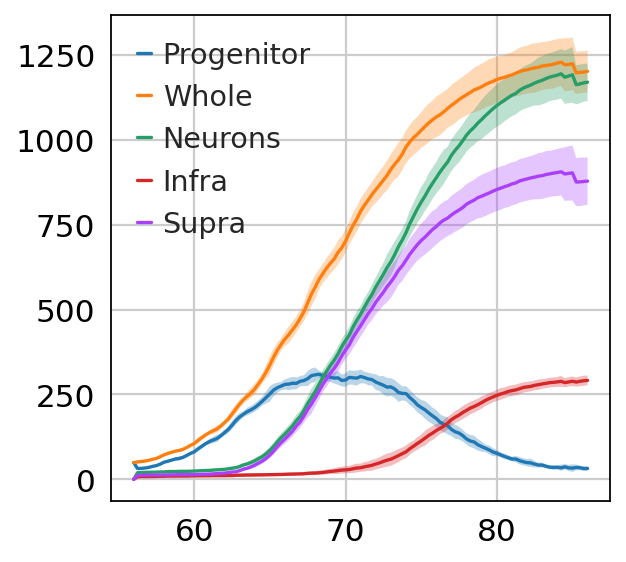

In [102]:
def show_mean_sd(stats_mean, stats_std):
    draw_mean_sd_line(stats_mean.time, stats_mean.progenitor_pop_size,
                     stats_std.progenitor_pop_size, label="Progenitor")
    draw_mean_sd_line(stats_mean.time, stats_mean.whole_pop_size,
                     stats_std.whole_pop_size, label="Whole")
    draw_mean_sd_line(stats_mean.time, stats_mean.neuron_pop_size,
                     stats_std.neuron_pop_size, label="Neurons")
    draw_mean_sd_line(stats_mean.time, stats_mean.infra_pop_size,
                     stats_std.infra_pop_size, label="Infra")
    draw_mean_sd_line(stats_mean.time, stats_mean.supra_pop_size,
                     stats_std.supra_pop_size, label="Supra")
    plt.legend()
    
show_mean_sd(mean_df, std_df)

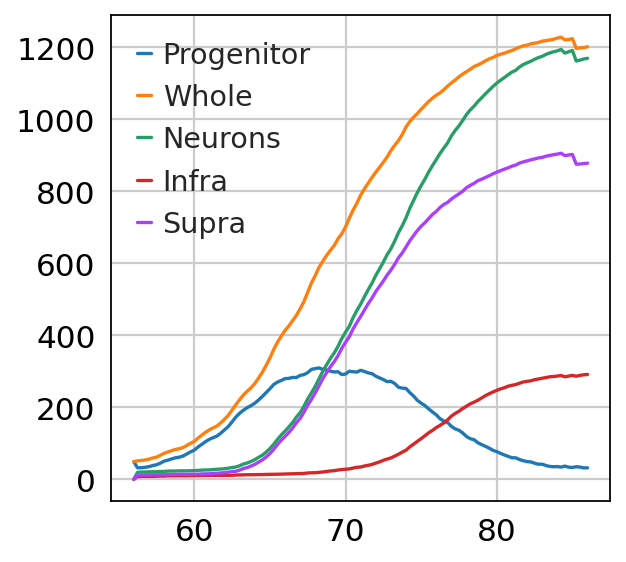

In [103]:
def quick_show(stats):
    plt.plot(stats.time, stats.progenitor_pop_size, label="Progenitor")
    plt.plot(stats.time, stats.whole_pop_size, label="Whole")
    plt.plot(stats.time, stats.neuron_pop_size, label="Neurons")
    plt.plot(stats.time, stats.infra_pop_size, label="Infra")
    plt.plot(stats.time, stats.supra_pop_size, label="Supra")
    plt.legend()
    
quick_show(mean_df)

## Single cell analysis

In [57]:
from anndata import AnnData
import scanpy as sp

In [55]:
def get_bb_recorded(prun, grn):
    from submodels.grn_bi_v1 import GRNCell
    ccls = factories["grn_bi1"](grn=grn)
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
        infra_pop_size=TypeNumberCallback(GRNCell.PostMitoticInfra, TargetPopulation.whole),
        supra_pop_size=TypeNumberCallback(GRNCell.PostMitoticSupra, TargetPopulation.whole),
    )
    bb = BrainModel(time_step=0.25, verbose=False, start_population=prun.size, max_pop_size=5e2,
            cell_cls=ccls, end_time=prun.end_time, start_time=56, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks, record_population=True)
    return bb

In [53]:
def build_scanpy_dataset(bb, min_age=0, max_age=1e6):
    # export expressions
    vec_age = []
    vec_gene_quantity = []
    for age in bb.snapshots:
        if age < min_age or age > max_age:
            continue
        for gene_quantity in bb.snapshots[age]["population"].values():
            vec_age.append(age)
            vec_gene_quantity.append(gene_quantity["quantity"])

    n_obs = len(vec_age)
    id_cells = np.arange(n_obs, dtype=int).astype(str)
    
    # metadata
    id_genes = np.array([f"gene_{i}" for i in range(len(vec_gene_quantity[0]))])
    obs_meta = pd.DataFrame({
        "age": np.array(vec_age)
    }, index=id_cells)
    
    # build dataset
    print(np.array(vec_gene_quantity).shape)
    df = pd.DataFrame(np.array(vec_gene_quantity), columns=id_genes, index=id_cells)
    dts = AnnData(df, obs=obs_meta)
    
    return dts

In [56]:
bb = get_bb_recorded(prun, grn)
bb.run()

False

In [58]:
dts = build_scanpy_dataset(bb)

(15710, 7)


In [89]:
sp.pp.neighbors(dts)
sp.tl.umap(dts)

In [120]:
# sp.pl.umap(dts, color="age")

In [94]:
# sp.pl.umap(dts, color="gene_5")

In [113]:
# sp.pl.umap(dts, color="gene_6")

In [93]:
# sp.pl.umap(dts, color="gene_4", vmax=3)

In [66]:
sp.tl.louvain(dts, resolution=0.2, key_added = "louvain") # default resolution in 1.0

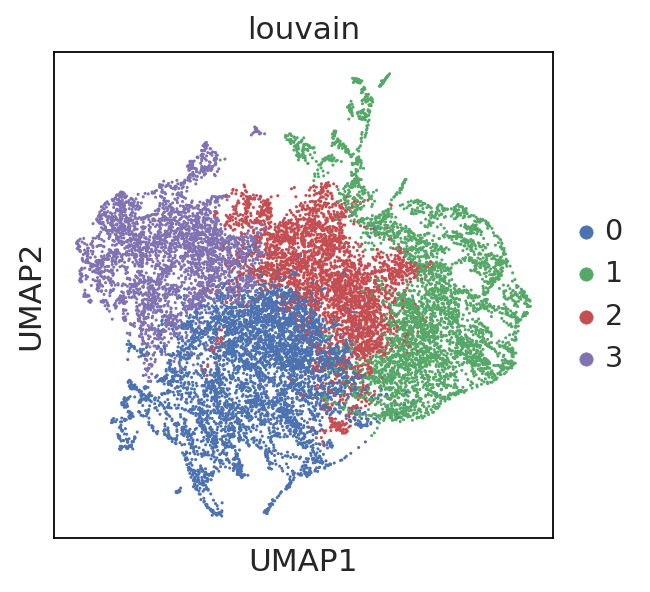

In [86]:
sp.pl.umap(dts, color='louvain')

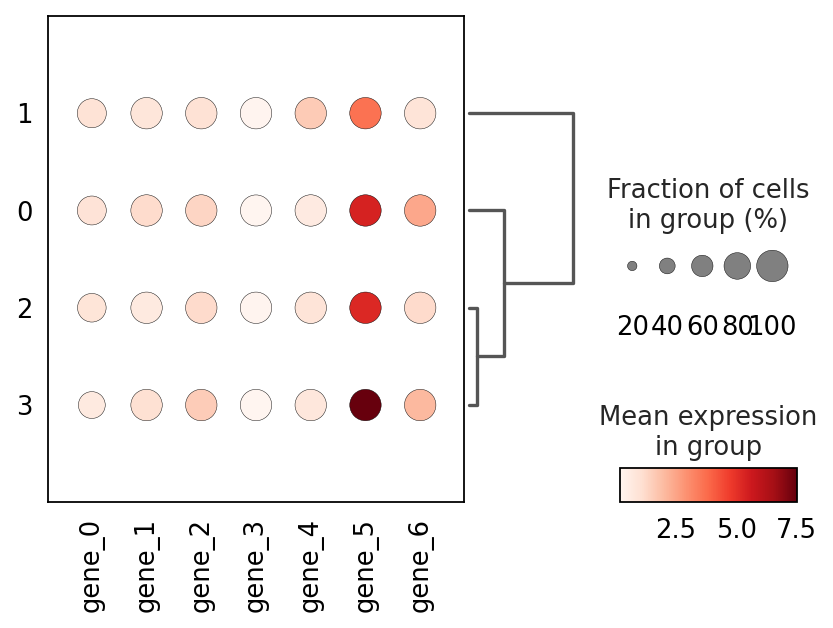

In [118]:
sp.settings.set_figure_params(dpi=80, format="png")
sp.pl.dotplot(dts, dts._var.index, groupby='louvain', dendrogram=True, figsize=(6, 4))

In [91]:
grn

>> G_0: init: 1.00; noise: 1.00; b: 1.61; m: 4.96; expr: 1.00; deg: 0.10; theta: 4.00; asym: 5.00; tree : 7
>> G_1: init: 1.38; noise: 1.00; b: 1.21; m: 6.67; expr: 1.00; deg: 0.10; theta: 6.53; asym: 5.00; tree : -7
>> G_2: init: 1.45; noise: 1.00; b: 1.18; m: 2.73; expr: 1.00; deg: 0.10; theta: 6.98; asym: 4.75; tree : ((3 AND 2) OR (-5 AND 7))
>> G_3: init: 0.61; noise: 6.06; b: 9.90; m: 8.77; expr: 0.68; deg: 1.10; theta: 2.18; asym: 1.42; tree : ((-7 OR -4) AND 6)
>> G_4: init: 2.07; noise: 1.00; b: 2.76; m: 1.39; expr: 1.00; deg: 0.10; theta: 7.17; asym: 5.00; tree : (6 AND -2)
>> G_5: init: 0.22; noise: 1.00; b: 2.25; m: 4.22; expr: 1.00; deg: 0.10; theta: 8.75; asym: 5.94; tree : (5 OR 4)
>> G_6: init: 0.69; noise: 1.00; b: 3.57; m: 9.22; expr: 0.93; deg: 0.10; theta: 6.40; asym: 5.00; tree : -5

### What's the role of each gene ?

In [99]:
def knock_out(grn, gene):
    grn = grn.copy()
    grn.set_mutable()
    grn._params[4, gene] = 0
    grn.compile()
    return grn

In [104]:
grn_ko3 = knock_out(grn, 3)
bb_ko3 = get_bb(prun, grn_ko3)
bb_ko3.run()

True

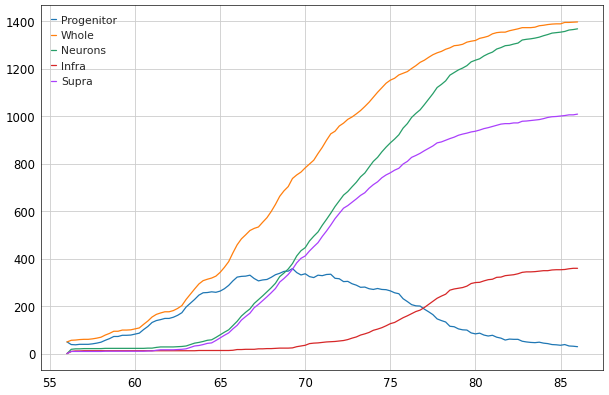

In [124]:
plt.figure(dpi=30, figsize=(12, 8))
quick_show(bb_ko3.stats)

In [106]:
grn_ko4 = knock_out(grn, 4)
bb_ko4 = get_bb(prun, grn_ko4)
bb_ko4.run()

False

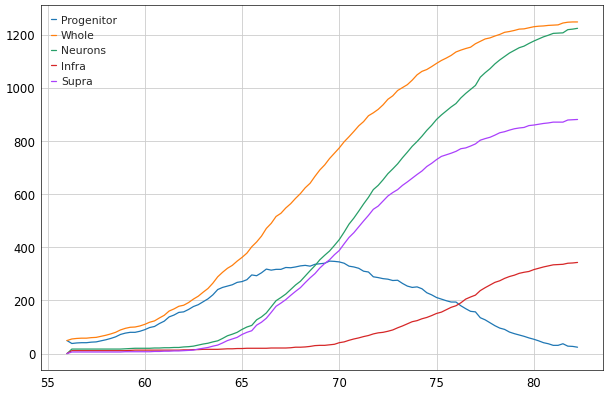

In [123]:
plt.figure(dpi=30, figsize=(12, 8))
quick_show(bb_ko4.stats)

In [108]:
grn_ko5 = knock_out(grn, 5)
bb_ko5 = get_bb(prun, grn_ko5)
bb_ko5.run()

False

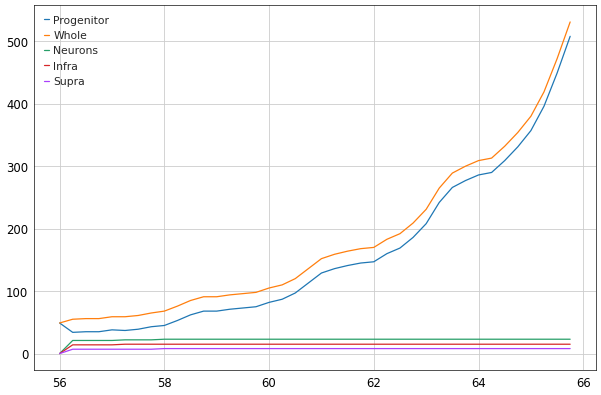

In [122]:
plt.figure(dpi=30, figsize=(12, 8))
quick_show(bb_ko5.stats)

In [110]:
grn_ko6 = knock_out(grn, 6)
bb_ko6 = get_bb(prun, grn_ko6)
bb_ko6.run()

True

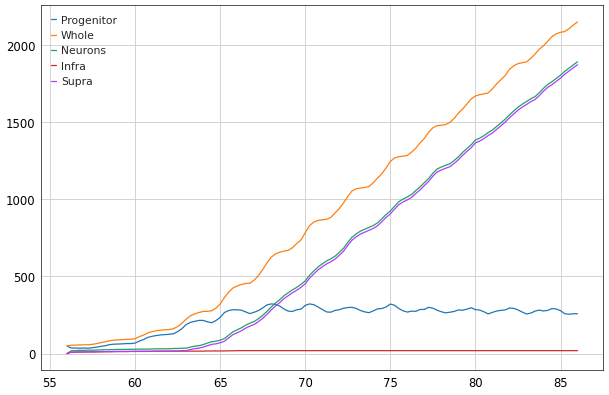

In [121]:
plt.figure(dpi=30, figsize=(12, 8))
quick_show(bb_ko6.stats)